## Importar librerías
Cargaremos las libs que utilizaremos para el ejercicio.

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


## Cargar las imagenes
Este proceso *plt.imread(filepath)*  cargará a memoria en un array las 77mil imágenes, por lo que puede tomar varios minutos y consumirá memoria RAM.

In [2]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\americano 1
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\basket 9348
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\beisball 8823
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\boxeo 7752
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\ciclismo 7125
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\f1 7533
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\futbol 5053
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\golf 7617
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\natacion 9768
C:\Users\Jorge Nieto\DocumentosD\IA\sportimages\tenis 5172
Directorios leidos: 10
Imagenes en cada directorio [9349, 8823, 7752, 7125, 7533, 5053, 7617, 9768, 5172, 8936]
suma Total de imagenes en subdirs: 77128


## Crear etiquetas y clases

Crearemos las etiquetas en *labels* , es decir, le daremos valores de 0 al 9 a cada deporte. Esto lo hacemos para poder usar el algoritmo supervisado e indicar que cuando cargamos una imagen de futbol en la red, ya sabemos que corresponde con la «etiqueta 6». Y con esa información, entrada y salida esperada, la red al entrenar, ajustará los pesos de las neuronas.

Luego convertimos las etiquetas y las imágenes en *numpy array* con *np.array()* 

In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [4]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [5]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Encontrando los valores de las etiquetas de entrenamiento
classes = np.unique(y)
nClasses = len(classes)
print('Total de salidas : ', nClasses)
print('Clases de salida : ', classes)

Total de salidas :  10
Clases de salida :  [0 1 2 3 4 5 6 7 8 9]


## Creamos sets de Entrenamiento y Test, Validación y Preprocesamiento

Nótese la forma de los arrays: veremos que son de 21×28×3, el 3 se refiere a los 3 canales de colores que tiene cada imagen: RGB (red, green, blue) que tiene valores de 0 a 255.

Preprocesamos el valor de los pixeles y lo normalizamos para que tengan un valor entre 0 y 1, por eso dividimos en 255.

Ademas haremos el «One-Hot encoding» con *to_categorical()*  que se refiere a convertir las etiquetas (nuestras clases) por ejemplo de fútbol un 6 a una salida de tipo (0 0 0 0 0 0 1 0 0 0) Esto es porque así funcionan mejor las redes neuronales para clasificar y se corresponde con una capa de salida de la red neuronal de 10 neuronas.

Por último en este bloque, subdividimos los datos en 80-20 para **test** y **entrenamiento** con *train_test_split()*  y nuevamente en 80-20 el de training para obtener un subconjunto de validación.

In [7]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 9')

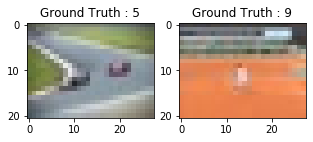

In [8]:
plt.figure(figsize=[5,5])

# Muestra la primera imagen del conjunto de entrenamiento
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Muestra la primera imagen de los datos de prueba
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## One-hot Encoding

In [10]:
# Cambio de etiquetas categoricas a estilo One-hot Encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Muestra el cambio
print('Etiqueta original:', train_Y[0])
print('Después de la conversión one-hot:', train_Y_one_hot[0])

Etiqueta original: 5
Después de la conversión one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Entrenamiento y evaluación

In [11]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


## Creamos la red 

Con Keras se crea la Convolutional Neural Network.


    Declaramos 3 «constantes»:
        El valor inicial del learning rate INIT_LR
        cantidad de epochs  y
        tamaño batch de imágenes a procesar batch_size.
    Crearemos una primer capa de neuronas  «Convolucional de 2 Dimensiones» Conv2D() , donde entrarán nuestras imágenes de 21x28x3.
    Aplicaremos 32 filtros (kernel) de tamaño 3×3 que detectan ciertas características de la imagen (ejemplo: lineas verticales).
    Utilizaremos La función LeakyReLU como activación de las neuronas.
    Haremos un MaxPooling (de 2×2) que reduce la imagen que entra de 21×28 a la mitad,(11×14) manteniendo las características «únicas» que detectó cada kernel.
    Para evitar el overfitting, añadimos una técnica llamada Dropout
    «Aplanamos» Flatten()  los 32 filtros y creamos una capa de 32 neuronas «tradicionales» Dense()
    Y finalizamos la capa de salida con 10 neuronas con activación Softmax, para que se corresponda con el «hot encoding» que hicimos antes.
    Luego compilamos nuestra red sport_model.compile()  y le asignamos un optimizador (en este caso de llama Adagrad).


In [12]:
INIT_LR = 1e-3
epochs = 6
batch_size = 64

sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))

sport_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 21, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                157728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)               

In [13]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

## Entrenamos la CNN

Con esta linea *sport_model.fit()*  iniciaremos el entrenamiento y validación de nuestra red. Pensemos que introduciremos miles de imágenes, pixeles, arrays, colores, filtros y la red se irá regulando sola, «aprendiendo» los mejores pesos para las más de 150.000 interconexiones para distinguir los 10 deportes. Esto tomará tiempo.

Por último guardamos la red YA ENTRENADA *sport_model.save()*  en un formato de archivo h5py ya que nos permitirá poder utilizarla en el futuro SIN necesidad de volver a entrenar.

In [14]:
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 49361 samples, validate on 12341 samples
Epoch 1/6
49361/49361 [==============================] - 22s 453us/step - loss: 1.4820 - accuracy: 0.5084 - val_loss: 1.0114 - val_accuracy: 0.7895
Epoch 2/6
49361/49361 [==============================] - 20s 399us/step - loss: 1.1498 - accuracy: 0.6272 - val_loss: 0.8424 - val_accuracy: 0.7938
Epoch 3/6
49361/49361 [==============================] - 20s 396us/step - loss: 1.0439 - accuracy: 0.6616 - val_loss: 0.7638 - val_accuracy: 0.8268
Epoch 4/6
49361/49361 [==============================] - 19s 384us/step - loss: 0.9791 - accuracy: 0.6867 - val_loss: 0.7118 - val_accuracy: 0.8322
Epoch 5/6
49361/49361 [==============================] - 19s 389us/step - loss: 0.9318 - accuracy: 0.7029 - val_loss: 0.6705 - val_accuracy: 0.8530
Epoch 6/6
49361/49361 [==============================] - 19s 381us/step - loss: 0.9014 - accuracy: 0.7139 - val_loss: 0.6399 - val_accuracy: 0.8597


In [15]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

## Evaluamos la red

In [16]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

15426/15426 [==============================] - 2s 106us/step


In [17]:
print('Pérdida:', test_eval[0])
print('Presición:', test_eval[1])

Pérdida: 0.6426831030527256
Presición: 0.860819399356842


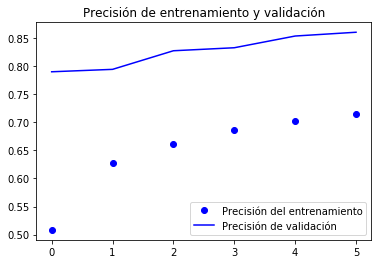

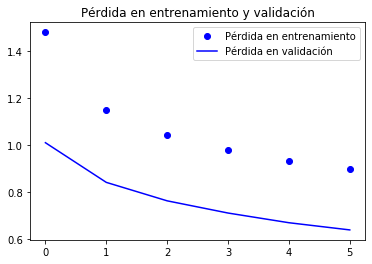

In [18]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Precisión del entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.legend()
plt.show()

In [19]:
predicted_classes2 = sport_model.predict(test_X)
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

## ¿Qué se puede mejorar?

Hay 13279 etiquetas correctas


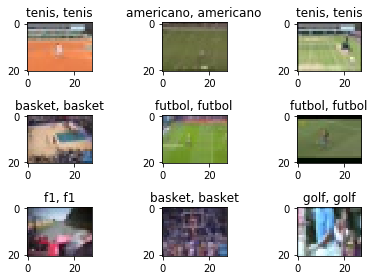

In [20]:
correct = np.where(predicted_classes==test_Y)[0]
print("Hay %d etiquetas correctas" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Hay 2147 etiquetas icorrectas


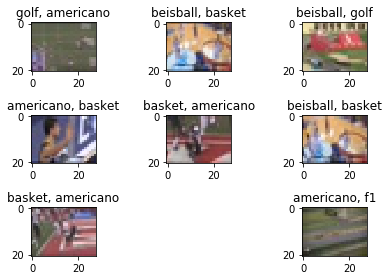

In [21]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Hay %d etiquetas icorrectas" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [22]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.79      0.67      0.72      1926
     Class 1       0.84      0.91      0.87      1750
     Class 2       0.82      0.77      0.79      1558
     Class 3       0.88      0.93      0.90      1421
     Class 4       0.97      0.99      0.98      1501
     Class 5       0.83      0.59      0.69       960
     Class 6       0.92      0.84      0.87      1513
     Class 7       0.73      0.92      0.81      2003
     Class 8       0.93      0.94      0.94      1010
     Class 9       0.99      1.00      1.00      1784

    accuracy                           0.86     15426
   macro avg       0.87      0.85      0.86     15426
weighted avg       0.86      0.86      0.86     15426



## Resultados obtenidos

Ya con nuestra red entrenada, es la hora de la verdad: ponerla a prueba con el set de imágenes para Test que separamos al principio y que son muestras que nunca fueron «vistas» por la máquina.

In [23]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Pérdida de la prueba:', test_eval[0])
print('Presición de la prueba:', test_eval[1])

15426/15426 [==============================] - 2s 115us/step
Pérdida de la prueba: 0.6426831030527256
Presición de la prueba: 0.860819399356842


## Probemos el clasificador

In [24]:
from keras import models
from skimage.transform import resize

model = models.load_model('sports_mnist.h5py')

images=[]
filenames=['test_futbol.png','test_basket.png']

for filepath in filenames:
    image = plt.imread(filepath)
    image_resized = resize(image,(21,28,3),preserve_range=True)
    images.append(image_resized)
    
X = np.array(images, dtype=np.uint8)#convertir de lista a numpy
test_X=X.astype('float32')
test_X=test_X/255.

predicted_classes=model.predict(test_X)
prediccion=predicted_classes[1] #para ver la predicción de la primera foto

print(prediccion)

[0.06445732 0.01878724 0.01292877 0.3829449  0.17172474 0.02841834
 0.04703004 0.00841363 0.25647977 0.00881518]
